In [62]:
from keras.models import Sequential
from keras.layers import Convolution2D, Dense
import numpy as np
import matplotlib.image as mpImg
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

## Load data

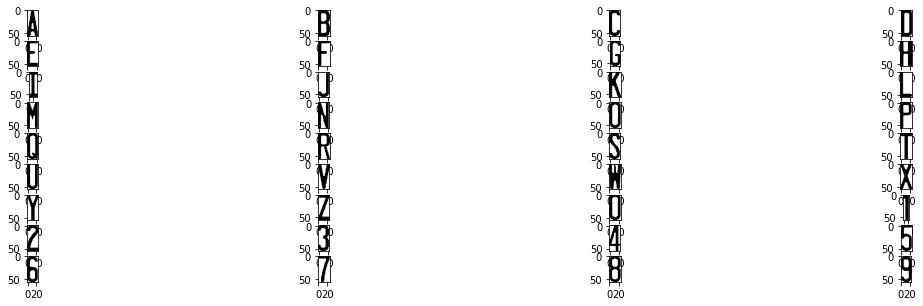

In [253]:
chars_dataset = r'C:\Users\User\Desktop\coding\projects\github\deep_learning\openCV\ANPR\chars_dataset\anpr_first_try_fonts.jpg'
chars_dataset = mpImg.imread(chars_dataset)
gray = cv2.cvtColor(chars_dataset, cv2.COLOR_RGB2GRAY)

"""
Using cv2.findContours, we can easily find all of the characters including their location/width/height.
Store those info into a list for later use.
"""
_, binary = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)
_, cnts, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
lines = 8
characters_per_line = 36
num_characters = lines * characters_per_line


indices = [number for number in range(len(cnts))]
sorted_cnts = []


for i, cnt in enumerate(cnts):
    x, y, w, h = cv2.boundingRect(cnt)
    sorted_cnts.append([x, y, w, h]) 

"""
The cnts list variable stores all the positions of every characters.
Notice that order of cnts in the list is random, meaning it could be very annoying when we loop through the whole list
to label every single character, because you won't know what's the next character.
Let's rearrange the list and make the labeling process easilier.
"""
sorted_cnts = sorted(sorted_cnts, key = lambda x:x[1])
line1 = sorted(sorted_cnts[:36], key = lambda x:x[0])
line2 = sorted(sorted_cnts[36:72], key = lambda x:x[0])
line3 = sorted(sorted_cnts[72:108], key = lambda x:x[0])
line4 = sorted(sorted_cnts[108:144], key = lambda x:x[0])
line5 = sorted(sorted_cnts[144:180], key = lambda x:x[0])
line6 = sorted(sorted_cnts[180:216], key = lambda x:x[0])
line7 = sorted(sorted_cnts[216:252], key = lambda x:x[0])
line8 = sorted(sorted_cnts[252:288], key = lambda x:x[0])

"""
Vis
"""
f, axs = plt.subplots(9, 4, figsize=(20, 5))
for index, image in enumerate(line1):
    idx_row = index // 4
    inx_col = index % 4
    x, y, w, h = image
    sliced_img = chars_dataset[y:y+h,x:x+w,:]
    axs[idx_row][inx_col].imshow(sliced_img)

### Resizing images
Seems everything worked out fine, but there's still an issue, seems all the characters share the same height but they don't share the same width. Some of them are wide and some of them are narrow. Before we use them to train our classifier, we must take care of this issue. An easy way the solve this is to make the widths of every characters equal to their heights.

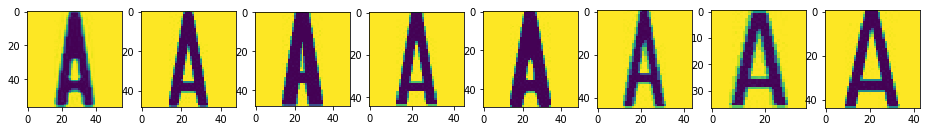

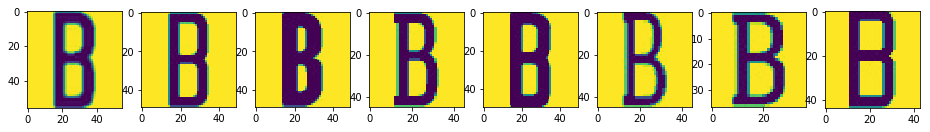

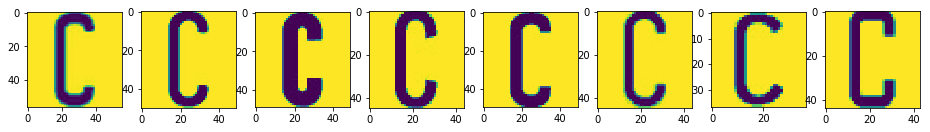

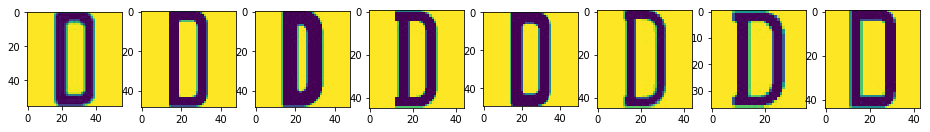

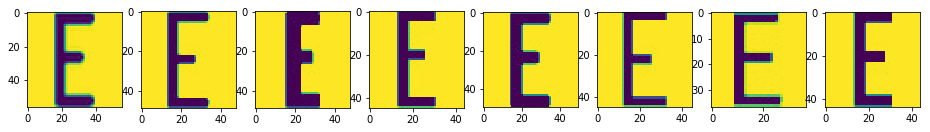

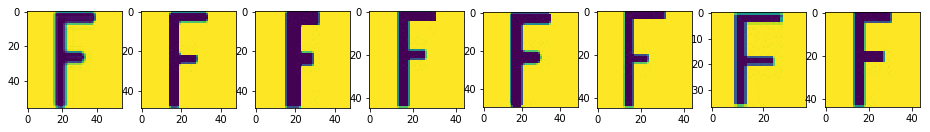

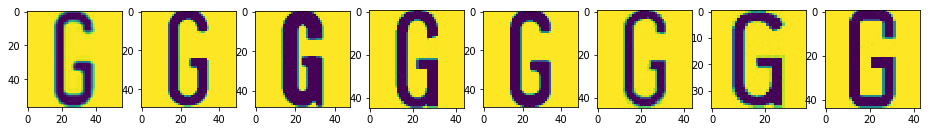

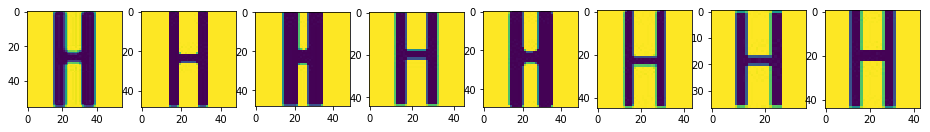

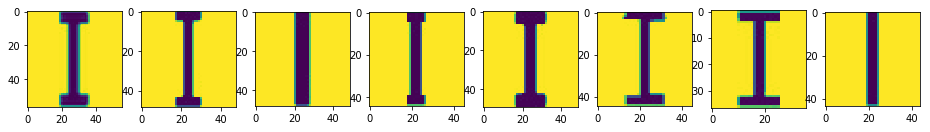

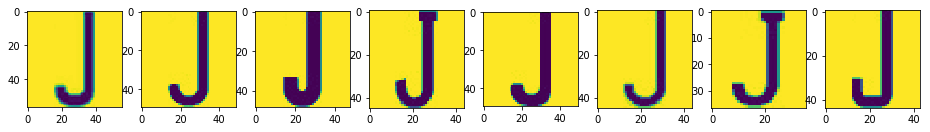

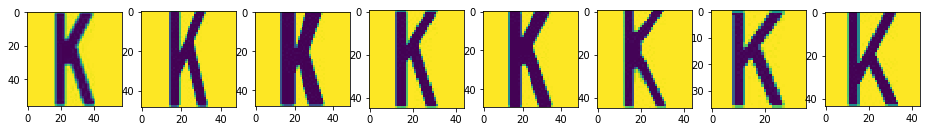

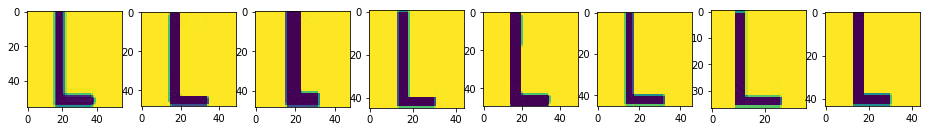

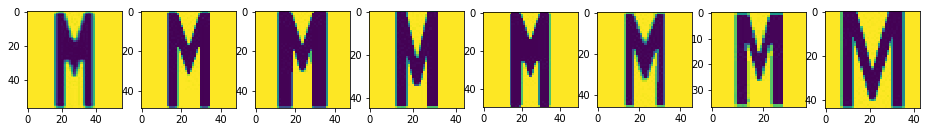

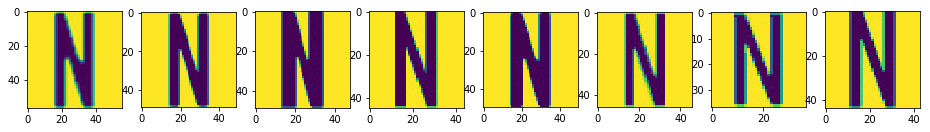

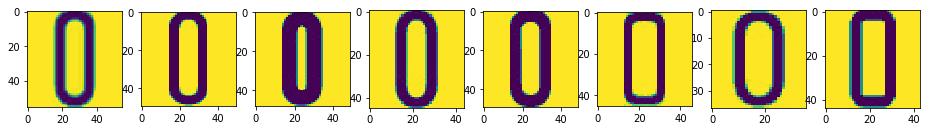

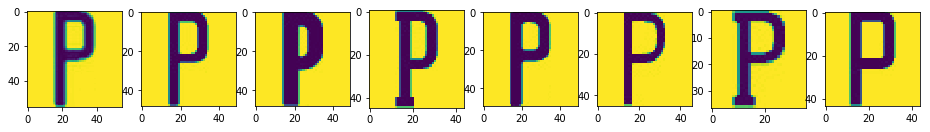

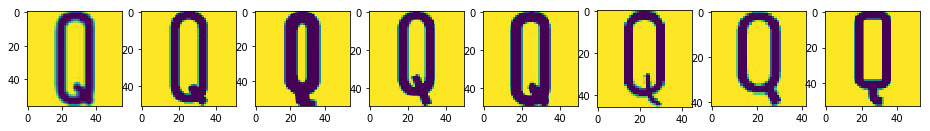

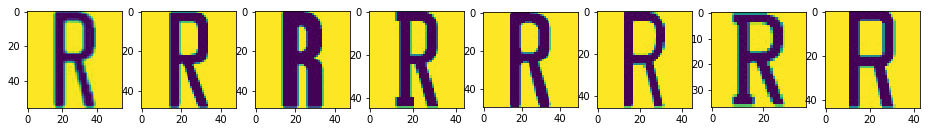

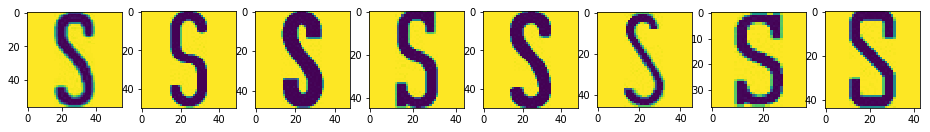

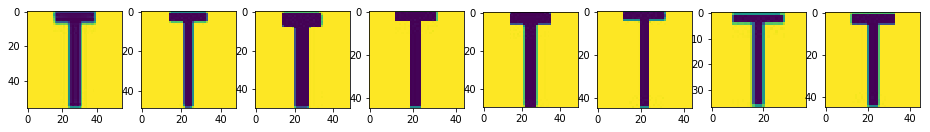

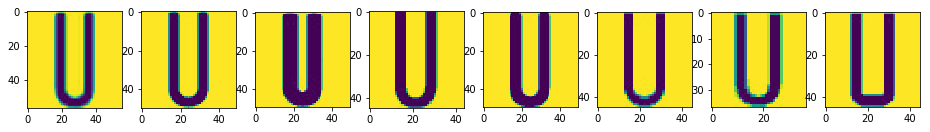

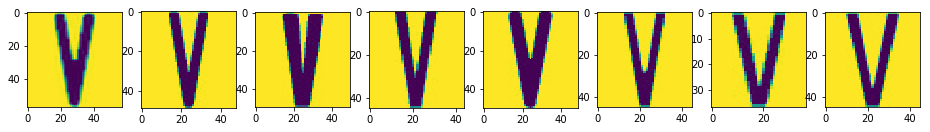

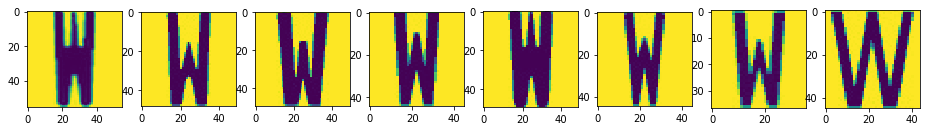

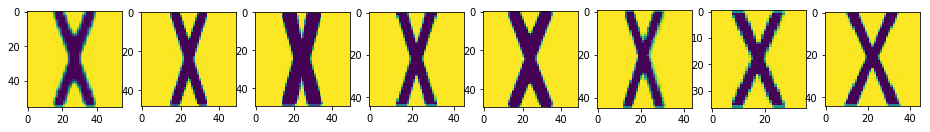

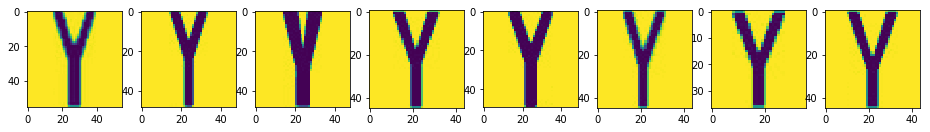

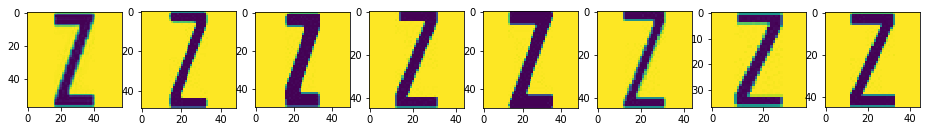

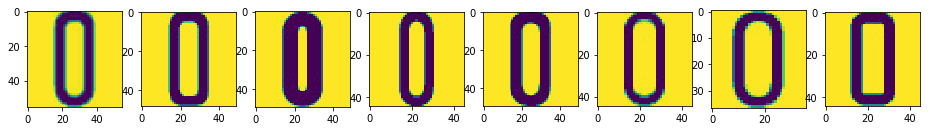

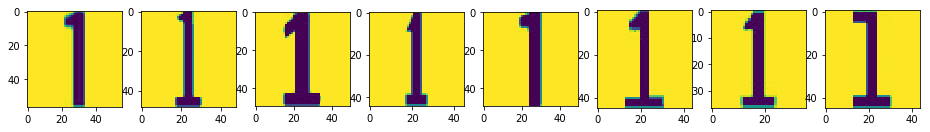

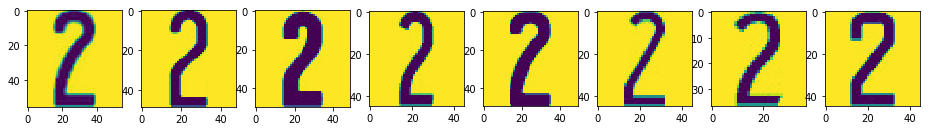

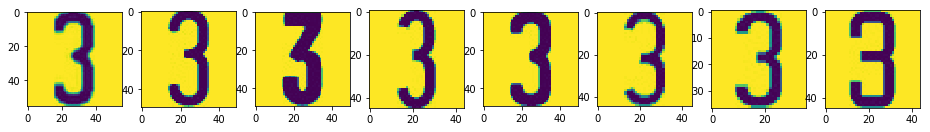

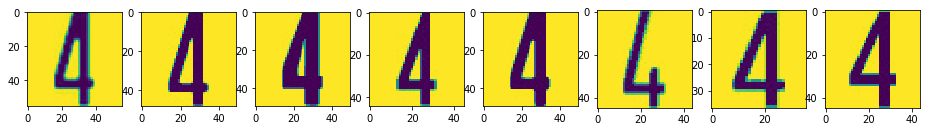

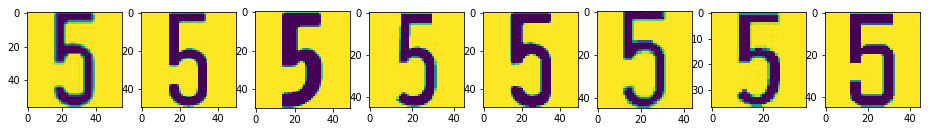

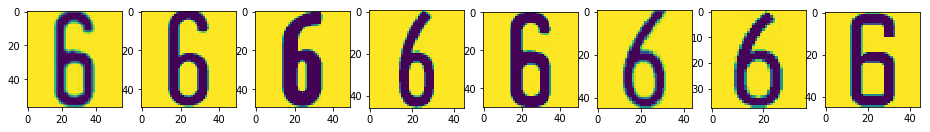

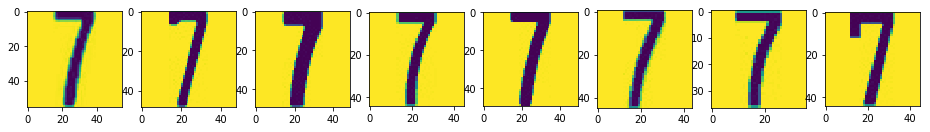

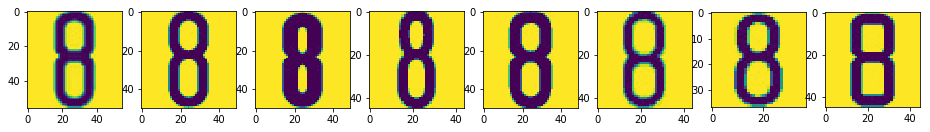

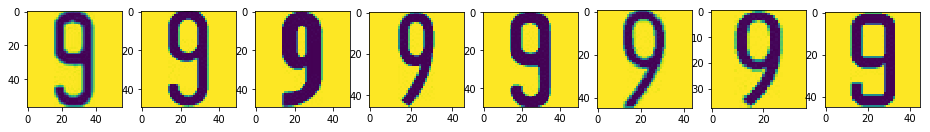

In [254]:
"""
Let the height of a character be A , width be B, and the difference is C = A - B. 
Now devide the difference by two, we know how many pixels we should add to the width to make it equals to the height.
"""
for cols in zip(line1, line2, line3, line4, line5, line6, line7, line8):
    _, axes = plt.subplots(1, 8, figsize = (16, 2))
    for i, col in enumerate(cols):
        x, y, w, h = col
        extra_width = (h - w) // 2
        extension = np.uint8(np.ones((h, extra_width)))*255
        sliced_img = chars_dataset[y:y+h,x:x+w,:]
        sliced_img = cv2.cvtColor(sliced_img, cv2.COLOR_RGB2GRAY)
        output = np.hstack((extension, sliced_img, extension))
        axes[i].imshow(output)
    plt.show()

## Generate data
Everything is doing great, now it's time to generate the data for training.

In [255]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [188]:
characters = []
labels = []

for num_col, cols in enumerate(zip(line1, line2, line3, line4, line5, line6, line7, line8)):
    for col in cols:
        x, y, w, h = col
        fill = (h - w) // 2
        extension = np.uint8(np.ones((h, fill)))*255
        sliced_img = chars_dataset[y:y+h,x:x+w,:]
        sliced_img = cv2.cvtColor(sliced_img, cv2.COLOR_RGB2GRAY)
        output = np.hstack((extension, sliced_img, extension))
        sliced_img = cv2.resize(output, (32, 32))
        flatten = sliced_img.reshape((1024, ))
        characters.append(flatten)
        labels.append(np.eye(characters_per_line)[num_col])

characters = np.array(characters)
labels = np.array(labels)

In [189]:
characters, labels = shuffle(characters, labels)
X_train, X_test, y_train, y_test = train_test_split(characters, labels, test_size = 0.1)

#Normalizing the data values to be numbers between 0 and 1
X_train = X_train / 255
X_test = X_test / 255

## Model
The architecture of my model has only two fully-connected layers, since the characters are just simple shape, a CNN architecture is not necessary.

In [190]:
from keras.layers import Dense, MaxPool2D, Dense, Convolution2D, Flatten, Lambda
from keras.models import Sequential

In [194]:
model = Sequential()
model.add(Dense(128, input_shape=(1024, )))
model.add(Dense(64))
model.add(Dense(36, activation='softmax'))
model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test), shuffle=True)

Train on 259 samples, validate on 29 samples
Epoch 1/50
259/259 [==============================] - 0s - loss: 9.0463 - acc: 0.0193 - val_loss: 12.6699 - val_acc: 0.0345
Epoch 2/50
259/259 [==============================] - 0s - loss: 6.6675 - acc: 0.0888 - val_loss: 7.2135 - val_acc: 0.0345
Epoch 3/50
259/259 [==============================] - 0s - loss: 5.1168 - acc: 0.1120 - val_loss: 4.8935 - val_acc: 0.1034
Epoch 4/50
259/259 [==============================] - 0s - loss: 3.0768 - acc: 0.2703 - val_loss: 8.3144 - val_acc: 0.0690
Epoch 5/50
259/259 [==============================] - 0s - loss: 2.9392 - acc: 0.2664 - val_loss: 7.7240 - val_acc: 0.0345
Epoch 6/50
259/259 [==============================] - 0s - loss: 2.7859 - acc: 0.3514 - val_loss: 4.7787 - val_acc: 0.1034
Epoch 7/50
259/259 [==============================] - 0s - loss: 2.2029 - acc: 0.4093 - val_loss: 5.2915 - val_acc: 0.1724
Epoch 8/50
259/259 [==============================] - 0s - loss: 2.2170 - acc: 0.4556 - val_l

In [262]:
model.save('ANPR_Model.h5')

## Helper function
The model takes in inputs that have a specific shape, i defined a function that convert inputs into the form that my model will be.

In [228]:
def preprocessedData(img):
    image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    _, thre = cv2.threshold(image, 100, 255, cv2.THRESH_BINARY)
    extra_widths = (image.shape[0] - image.shape[1]) // 2
    extension = np.uint8(np.ones((image.shape[0], extra_widths)))*255
    reshaped = np.hstack((extension, thre, extension))
    resized= cv2.resize(reshaped, (32, 32))
    return resized

## Test on real car plate data

Prediction is 4


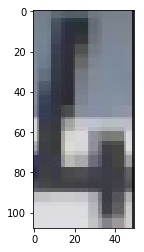

Prediction is 5


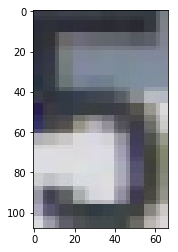

Prediction is Z


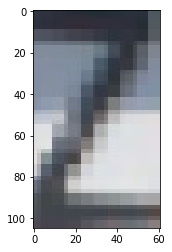

Prediction is 3


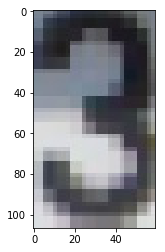

In [263]:
import glob

pred_mapping = [
                'A','B','C','D','E','F','G',
                'H','I','J','K','L','M','N',
                'O','P','Q','R','S','T','U',
                'V','W','X','Y','Z','0','1',
                '2','3','4','5','6','7','8','9']

name_images = glob.glob(r'test_sets\*')
for name_img in name_images:
    image = mpImg.imread(name_img)
    preprocessed = preprocessedData(image)
    
    flatten = preprocessed.reshape((1024, ))
    flatten = np.array([flatten])
    pred = model.predict(flatten)
    index = np.argmax(pred)
    msg = 'Prediction is {}'.format(pred_mapping[index])
    print(msg)
    
    plt.imshow(image)
    plt.show()